## RNN-LSTM for stock price prediction

### Imports

In [1]:
import yfinance as yf
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from copy import deepcopy as dc

### GPU setting

In [2]:
#use GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Data download

In [3]:
# Download data
start, end, stock = '2013-11-20', '2023-11-21', 'AAPL'
data = yf.download(stock, start, end)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-11-20,18.543928,18.586430,18.368929,18.392857,16.124863,193916800
2013-11-21,18.485714,18.614643,18.345358,18.612143,16.317110,262026800
2013-11-22,18.554285,18.648571,18.518929,18.564285,16.275150,223725600
2013-11-25,18.607857,18.781071,18.607143,18.705000,16.398510,229311600
2013-11-26,18.718571,19.147858,18.714287,19.049999,16.700972,401382800
...,...,...,...,...,...,...
2023-11-14,187.699997,188.110001,186.300003,187.440002,187.440002,60108400
2023-11-15,187.850006,189.500000,187.779999,188.009995,188.009995,53790500
2023-11-16,189.570007,190.960007,188.649994,189.710007,189.710007,54412900


### Data analysis

In [4]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2517.000000,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03
mean,75.971851,76.810181,75.188264,76.036297,74.074326,1.396766e+08
std,55.182104,55.834343,54.585715,55.240677,55.715299,8.640815e+07
min,17.684999,17.911785,17.626785,17.849285,15.648318,3.145820e+07
25%,29.377501,29.552500,29.122499,29.367500,26.946928,8.277270e+07
50%,47.382500,47.820000,46.912498,47.487499,45.411919,1.138600e+08
75%,132.429993,134.070007,130.929993,132.300003,130.748169,1.698056e+08
max,196.240005,198.229996,195.279999,196.449997,195.926956,1.065523e+09


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2013-11-20 to 2023-11-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2517 non-null   float64
 1   High       2517 non-null   float64
 2   Low        2517 non-null   float64
 3   Close      2517 non-null   float64
 4   Adj Close  2517 non-null   float64
 5   Volume     2517 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


In [6]:
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Data preprocessing

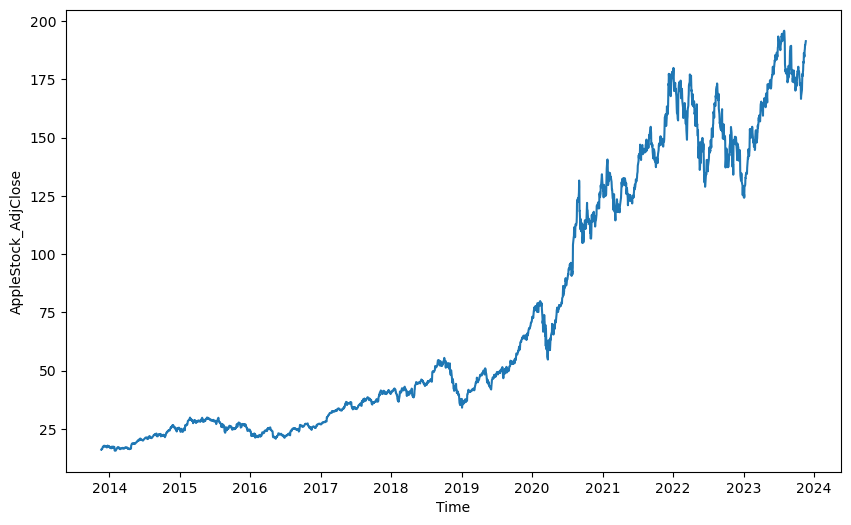

In [7]:
#Apple stock Adj Close VS Time
AdjClose_df = pd.DataFrame(data['Adj Close'])

plt.figure(figsize=(10, 6))
plt.plot(AdjClose_df, label='Actual Adj Close')
plt.xlabel('Time')
plt.ylabel('AppleStock_AdjClose')
plt.show()

In [8]:
#using MinMaxScaler() convert Adj Close to a new value between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scalered_AdjClose_df = scaler.fit_transform(AdjClose_df)
print(scalered_AdjClose_df)

[[-0.99471325]
 [-0.99258047]
 [-0.99304596]
 ...
 [ 0.93102955]
 [ 0.93080762]
 [ 0.95033289]]


In [9]:
# Create sequences values
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7 #set how many days adjclose value to be in one input
x, y = create_sequences(scalered_AdjClose_df, sequence_length)

print(x)
print(y)

[[[-0.99471325]
  [-0.99258047]
  [-0.99304596]
  ...
  [-0.98832193]
  [-0.98395916]
  [-0.98044734]]

 [[-0.99258047]
  [-0.99304596]
  [-0.99167742]
  ...
  [-0.98395916]
  [-0.98044734]
  [-0.98212856]]

 [[-0.99304596]
  [-0.99167742]
  [-0.98832193]
  ...
  [-0.98044734]
  [-0.98212856]
  [-0.976887  ]]

 ...

 [[ 0.84084441]
  [ 0.85269927]
  [ 0.84738116]
  ...
  [ 0.87655827]
  [ 0.90584626]
  [ 0.91216972]]

 [[ 0.85269927]
  [ 0.84738116]
  [ 0.89430847]
  ...
  [ 0.90584626]
  [ 0.91216972]
  [ 0.93102955]]

 [[ 0.84738116]
  [ 0.89430847]
  [ 0.87655827]
  ...
  [ 0.91216972]
  [ 0.93102955]
  [ 0.93080762]]]
[[-0.98212856]
 [-0.976887  ]
 [-0.97734541]
 ...
 [ 0.93102955]
 [ 0.93080762]
 [ 0.95033289]]


### Dataset setting

In [10]:
# Split the dataset (training, validation, testing) - (70%, 20%, 10%)
train_size = int(len(x) * 0.7)
val_size = int(len(x) * 0.9)

x_train, y_train = x[:train_size], y[:train_size]
x_val, y_val = x[train_size:val_size], y[train_size:val_size]
x_test, y_test = x[val_size:], y[val_size:]

x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

((1757, 7, 1), (502, 7, 1), (251, 7, 1), (1757, 1), (502, 1), (251, 1))

In [11]:
# Convert to PyTorch tensors
x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()
x_val = torch.tensor(x_val).float()
y_val = torch.tensor(y_val).float()
x_test = torch.tensor(x_test).float()
y_test = torch.tensor(y_test).float()

x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([1757, 7, 1]),
 torch.Size([502, 7, 1]),
 torch.Size([251, 7, 1]),
 torch.Size([1757, 1]),
 torch.Size([502, 1]),
 torch.Size([251, 1]))

In [12]:
# Dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [13]:
# Create datasets and dataloaders
batch_size = 8
train_dataset = TimeSeriesDataset(x_train, y_train)
val_dataset = TimeSeriesDataset(x_val, y_val)
test_dataset = TimeSeriesDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Model

In [14]:
# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [15]:
# Define training and validation functions
def train_one_epoch(model, train_loader, loss_function, optimizer):
    model.train()
    running_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_function(y_pred, y_batch)        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        

        # Print every 100 batches
        if (i + 1) % 100 == 0:
            print(f'Training - Epoch [{epoch+1}/{num_epochs}], Batch: {i+1}, Loss: {running_loss / (i+1):.4f}')
    
    return running_loss / len(train_loader)

def validate_one_epoch(model, val_loader, loss_function):
    model.eval()
    running_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(val_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        with torch.no_grad():
            y_pred = model(x_batch)
            loss = loss_function(y_pred, y_batch)
            running_loss += loss.item()

        # Print every 100 batches
        if (i + 1) % 100 == 0:
            print(f'Validation - Epoch [{epoch+1}/{num_epochs}], Batch: {i+1}, Loss: {running_loss / (i+1):.4f}')
    
    return running_loss / len(val_loader)


### Model initialization

In [16]:
# Initialize model, loss function, and optimizer
model = LSTM(1, 4, 1).to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Model Training

In [17]:
num_epochs = 75
train_losses, val_losses = [], []

start_time = time.time()

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, loss_function, optimizer)
    val_loss = validate_one_epoch(model, val_loader, loss_function)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
end_time = time.time()  # End time
training_time = end_time - start_time  # Calculate total training time

print(f"Training completed in: {training_time:.2f} seconds")

Training - Epoch [1/75], Batch: 100, Loss: 0.1626
Training - Epoch [1/75], Batch: 200, Loss: 0.1080
Epoch 1/75, Training Loss: 0.1027, Validation Loss: 0.9758
Training - Epoch [2/75], Batch: 100, Loss: 0.0421
Training - Epoch [2/75], Batch: 200, Loss: 0.0370
Epoch 2/75, Training Loss: 0.0354, Validation Loss: 0.5606
Training - Epoch [3/75], Batch: 100, Loss: 0.0108
Training - Epoch [3/75], Batch: 200, Loss: 0.0078
Epoch 3/75, Training Loss: 0.0074, Validation Loss: 0.3241
Training - Epoch [4/75], Batch: 100, Loss: 0.0032
Training - Epoch [4/75], Batch: 200, Loss: 0.0031
Epoch 4/75, Training Loss: 0.0030, Validation Loss: 0.2417
Training - Epoch [5/75], Batch: 100, Loss: 0.0023
Training - Epoch [5/75], Batch: 200, Loss: 0.0019
Epoch 5/75, Training Loss: 0.0019, Validation Loss: 0.1943
Training - Epoch [6/75], Batch: 100, Loss: 0.0013
Training - Epoch [6/75], Batch: 200, Loss: 0.0013
Epoch 6/75, Training Loss: 0.0013, Validation Loss: 0.1582
Training - Epoch [7/75], Batch: 100, Loss: 0.0

Training - Epoch [52/75], Batch: 100, Loss: 0.0002
Training - Epoch [52/75], Batch: 200, Loss: 0.0002
Epoch 52/75, Training Loss: 0.0002, Validation Loss: 0.0082
Training - Epoch [53/75], Batch: 100, Loss: 0.0002
Training - Epoch [53/75], Batch: 200, Loss: 0.0002
Epoch 53/75, Training Loss: 0.0002, Validation Loss: 0.0090
Training - Epoch [54/75], Batch: 100, Loss: 0.0002
Training - Epoch [54/75], Batch: 200, Loss: 0.0002
Epoch 54/75, Training Loss: 0.0002, Validation Loss: 0.0083
Training - Epoch [55/75], Batch: 100, Loss: 0.0002
Training - Epoch [55/75], Batch: 200, Loss: 0.0002
Epoch 55/75, Training Loss: 0.0002, Validation Loss: 0.0082
Training - Epoch [56/75], Batch: 100, Loss: 0.0001
Training - Epoch [56/75], Batch: 200, Loss: 0.0002
Epoch 56/75, Training Loss: 0.0002, Validation Loss: 0.0067
Training - Epoch [57/75], Batch: 100, Loss: 0.0002
Training - Epoch [57/75], Batch: 200, Loss: 0.0002
Epoch 57/75, Training Loss: 0.0002, Validation Loss: 0.0069
Training - Epoch [58/75], Ba

### Plotting and Testing

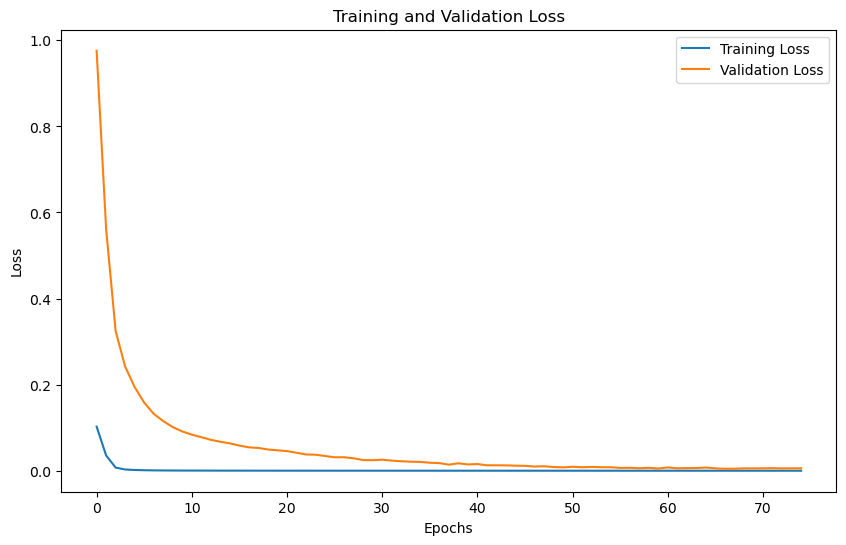

In [18]:
# training and validation losses VS epochs
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

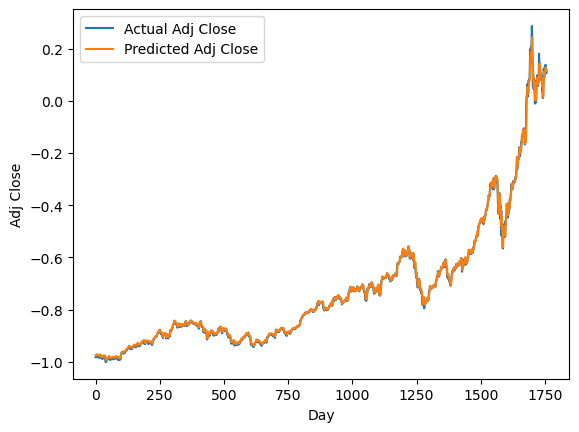

In [19]:
# training stage - scalered adj close VS day
with torch.no_grad():
    predicted = model(x_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Adj Close')
plt.plot(predicted, label='Predicted Adj Close')
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

In [20]:
#inverted back to original Adj Close price
train_predictions = predicted.flatten()

output = np.zeros((x_train.shape[0], sequence_length+1))
output[:, 0] = train_predictions
output = scaler.inverse_transform(output)

train_predictions = dc(output[:, 0])
train_predictions

array([ 17.76704587,  17.81076371,  18.07549385, ..., 117.06922266,
       116.11050338, 116.0672476 ])

In [21]:
output[:, 0] = y_train.flatten()
output = scaler.inverse_transform(output)

new_y_train = dc(output[:, 0])
new_y_train

array([ 17.25923767,  17.73170948,  17.69038787, ..., 115.98164334,
       116.5810625 , 115.30361925])

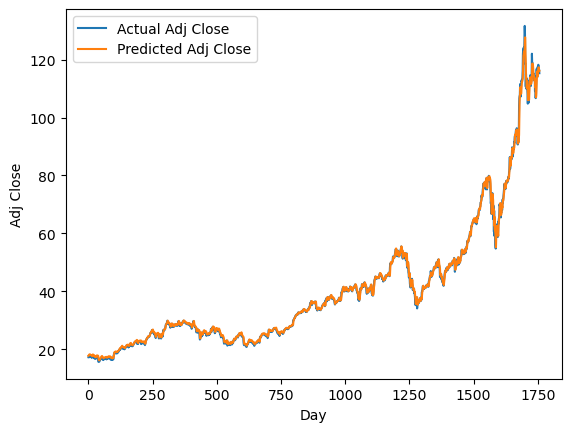

In [22]:
# training stage - actual adj close VS day
plt.plot(new_y_train, label='Actual Adj Close')
plt.plot(train_predictions, label='Predicted Adj Close')
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.show()

In [23]:
# Test for the prediction
test_predictions = model(x_test.to(device)).detach().cpu().numpy().flatten()

output = np.zeros((x_test.shape[0], sequence_length+1))
output[:, 0] = test_predictions
output = scaler.inverse_transform(output)

test_predictions = dc(output[:, 0])
test_predictions

array([145.05683341, 144.07017598, 144.46323896, 144.94234607,
       144.04094837, 142.06803647, 139.80390691, 141.58148813,
       142.38464561, 142.60985937, 142.30139528, 140.65081984,
       139.01844718, 138.93961054, 138.61417402, 139.48063022,
       140.28613558, 139.74033686, 136.52579963, 134.07691021,
       131.80616683, 130.69924102, 131.77432002, 130.63779588,
       130.03726793, 128.81986821, 126.15755547, 126.94332413,
       127.40607669, 125.02550412, 124.76344154, 123.89202094,
       126.06928433, 127.22016976, 128.05181609, 129.83533417,
       130.50773303, 131.4761044 , 132.44231593, 132.50555556,
       132.56843521, 133.83590871, 135.87338461, 137.39905501,
       137.81751753, 138.95954334, 140.29166411, 139.66282997,
       139.96156944, 140.54636875, 142.97271153, 145.42915768,
       145.63126874, 146.8797819 , 146.50773701, 145.97125996,
       145.81587009, 146.72388699, 146.90301892, 147.77244355,
       147.64364328, 147.21512572, 145.50374718, 144.80

In [24]:
output = np.zeros((x_test.shape[0], sequence_length+1))
output[:, 0] = y_test.flatten()
output = scaler.inverse_transform(output)

new_y_test = dc(output[:, 0])
new_y_test

array([147.18728696, 149.34523004, 150.23030004, 147.2867441 ,
       143.41834928, 140.38532946, 147.20718483, 147.48564227,
       146.98841834, 145.81495673, 142.11566296, 140.15660194,
       141.85707116, 141.36981094, 143.68685912, 144.66142255,
       142.41398604, 135.74125594, 133.76231316, 131.63421555,
       131.56460656, 134.69709696, 131.49499489, 131.12706013,
       129.30723589, 125.33940944, 128.88957122, 129.20777874,
       124.37480166, 125.65763845, 124.32508115, 128.89950538,
       129.42654524, 130.00334188, 132.74800233, 132.66845649,
       134.01095468, 135.18438673, 134.45845139, 134.51811278,
       137.10363857, 140.32565195, 141.73774838, 141.07148786,
       143.15981926, 145.11885074, 142.20515371, 143.48796095,
       144.6216268 , 149.98169076, 153.64120489, 150.88661028,
       153.79035703, 151.07554742, 150.03137232, 150.39988732,
       153.22844014, 152.581054  , 154.70245182, 153.08899114,
       151.93368397, 147.88012633, 148.30838064, 148.79

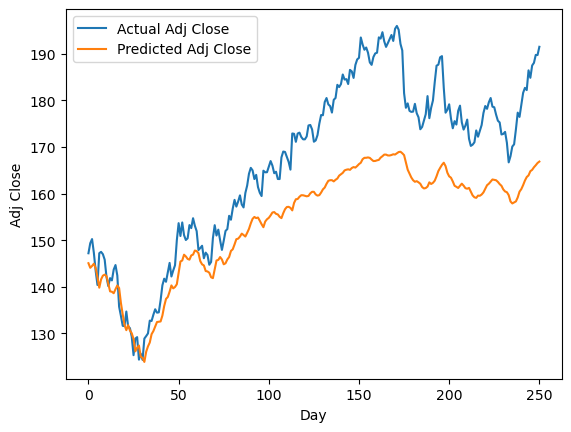

In [25]:
#stock prediciton testing
plt.plot(new_y_test, label='Actual Adj Close')
plt.plot(test_predictions, label='Predicted Adj Close')
plt.xlabel('Day')
plt.ylabel('Adj Close')
plt.legend()
plt.show()